# Cumulated Graph of the Distance traveled:

This script provides the figure for cumulated water point. (note that you need to build the event "Water Stop" to get this graph)

*Warning: we set the waterpoint at the bottom right of the cage. If you use another location, change the code of the rebuildWaterPoint.py file.*

| ![](../images/cumulatedwaterpoint1.jpg) ![](../images/cumulatedwaterpoint2.jpg) ![](../images/cumulatedwaterpoint3.jpg) ![](../images/cumulatedwaterpoint4.jpg)
|:--:| 
|Example of cumulated water point|

Code launched.


Start :  0


Entry (in frame) : 0


End :  1200000


Entry (in frame) : 1200000
There will be 66 bins of 10min (18000frames) in the graph
The timebinList is: [0, 18000, 36000, 54000, 72000, 90000, 108000, 126000, 144000, 162000, 180000, 198000, 216000, 234000, 252000, 270000, 288000, 306000, 324000, 342000, 360000, 378000, 396000, 414000, 432000, 450000, 468000, 486000, 504000, 522000, 540000, 558000, 576000, 594000, 612000, 630000, 648000, 666000, 684000, 702000, 720000, 738000, 756000, 774000, 792000, 810000, 828000, 846000, 864000, 882000, 900000, 918000, 936000, 954000, 972000, 990000, 1008000, 1026000, 1044000, 1062000, 1080000, 1098000, 1116000, 1134000, 1152000, 1170000, 1188000] 

 with a length of 67.

 This script will plot the totalDistance traveled by the mice in the selected database... 

E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221026_Amphet_Cage2_7-3Amphet.sqlite
expName is:  _Amphet_Cage2_7-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID

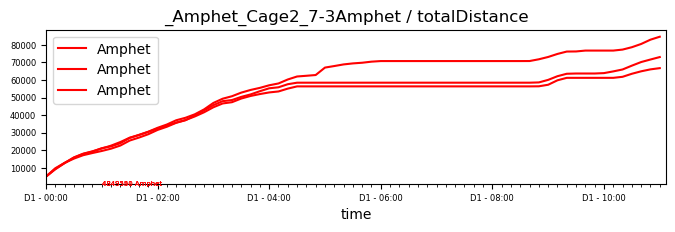

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221027_Amphet_Cage1_8-2NaCl.sqlite
expName is:  27_Amphet_Cage1_8-2NaCl
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849076 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849319 Genotype:NaCl User1:None
000004849076
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  34.213462352752686 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849076 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849076 Genotype:NaCl User1:None   821252  detections loaded in 15.046928405761719 seconds.
Compute total distance min:0 max:1200000 
The time bin is 10min = 18 000 frames.
Compute t

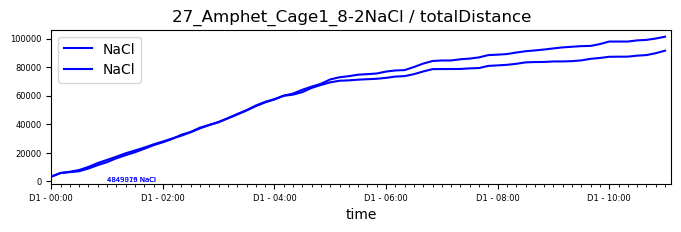

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221027_Amphet_Cage2_8-3NaCl.sqlite
expName is:  27_Amphet_Cage2_8-3NaCl
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849551 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849390 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849540 Genotype:NaCl User1:None
000004849551
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  52.804569244384766 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849551 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849551 Genotype:NaCl User1:None   715301  detections loaded in 17.42956829071045 seconds.
Compute total distance min:0 

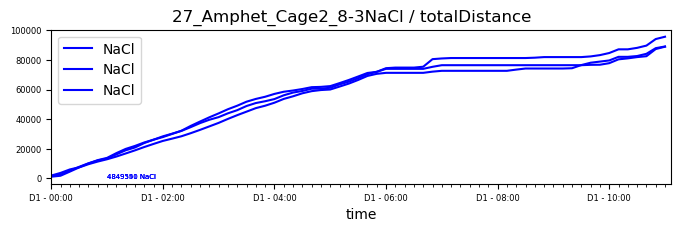

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221028_Amphet_Cage3_weekend1.sqlite
expName is:  8_Amphet_Cage3_weekend1
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849094 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849427 Genotype:NaCl User1:None
000004849177
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  222.53313994407654 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None   1031541  detections loaded in 27.39825701713562 seconds.
Compute total distance min:

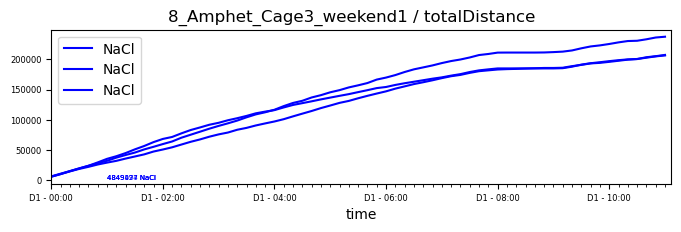

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221028_Amphet_Cage4_weekend1.sqlite
expName is:  8_Amphet_Cage4_weekend1
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849182 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849320 Genotype:NaCl User1:None
000004849491
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  164.66514682769775 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None   1144806  detections loaded in 28.69476342201233 seconds.
Compute total distance min:

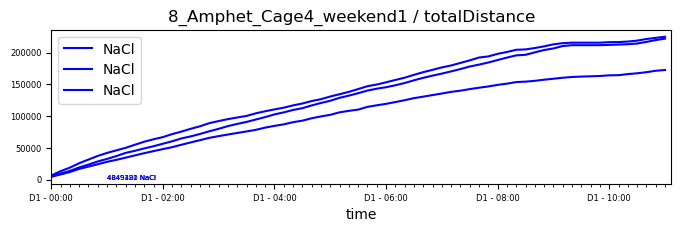

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221031_Amphet_Cage3_1-3NaCl.sqlite
expName is:  31_Amphet_Cage3_1-3NaCl
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849427 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849094 Genotype:NaCl User1:None
000004849177
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  105.87962031364441 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None   918990  detections loaded in 22.587743520736694 seconds.
Compute total distance min:0

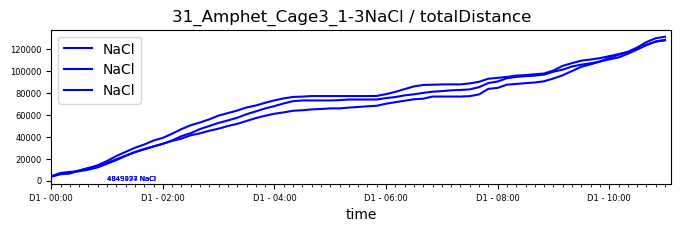

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221031_Amphet_Cage4_1-3NaCl.sqlite
expName is:  31_Amphet_Cage4_1-3NaCl
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849320 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849491 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849182 Genotype:NaCl User1:None
000004849320
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  69.44754672050476 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849320 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849320 Genotype:NaCl User1:None   836074  detections loaded in 19.62926721572876 seconds.
Compute total distance min:0 m

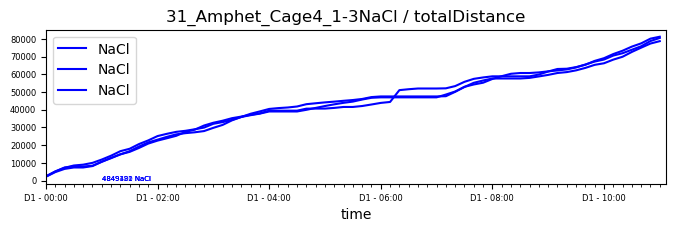

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221101_Amphet_Cage3_2-1Amphet.sqlite
expName is:  _Amphet_Cage3_2-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:3 Name:C RFID:000004849427 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849094 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849177 Genotype:NaCl User1:None
000004849427
totalDistance  Id( 3 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  55.888875007629395 S )
Computing the distance:
Animal Id:3 Name:C RFID:000004849427 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=3 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:3 Name:C RFID:000004849427 Genotype:Amphet User1:None   848611  detections loaded in 22.30013418197632 seconds.
Compute total distanc

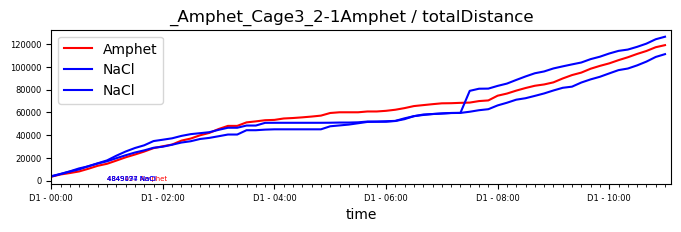

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221101_Amphet_Cage4_2-1Amphet.sqlite
expName is:  _Amphet_Cage4_2-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000004849320 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849182 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849491 Genotype:NaCl User1:None
000004849320
totalDistance  Id( 2 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  80.62096405029297 S )
Computing the distance:
Animal Id:2 Name:B RFID:000004849320 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:2 Name:B RFID:000004849320 Genotype:Amphet User1:None   916811  detections loaded in 21.038963556289673 seconds.
Compute total distanc

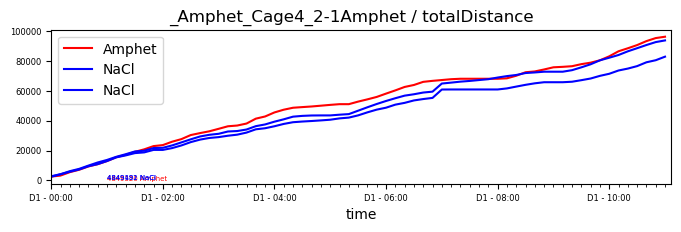

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221102_Amphet_Cage3_3-1Amphet.sqlite
expName is:  _Amphet_Cage3_3-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000004849177 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849427 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849094 Genotype:NaCl User1:None
000004849177
totalDistance  Id( 2 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  49.74584412574768 S )
Computing the distance:
Animal Id:2 Name:B RFID:000004849177 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:2 Name:B RFID:000004849177 Genotype:Amphet User1:None   818271  detections loaded in 18.333529710769653 seconds.
Compute total distanc

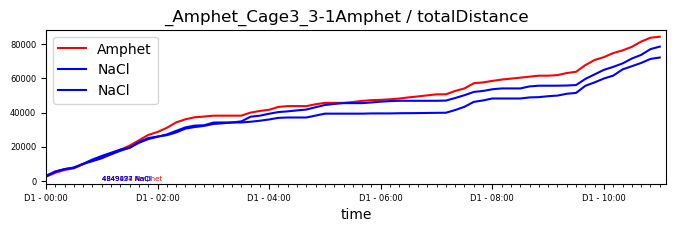

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221102_Amphet_Cage4_3-1Amphet.sqlite
expName is:  _Amphet_Cage4_3-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000004849182 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849320 Genotype:NaCl User1:None
000004849182
totalDistance  Id( 2 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  80.62649035453796 S )
Computing the distance:
Animal Id:2 Name:B RFID:000004849182 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:2 Name:B RFID:000004849182 Genotype:Amphet User1:None   836025  detections loaded in 19.33108115196228 seconds.
Compute total distance

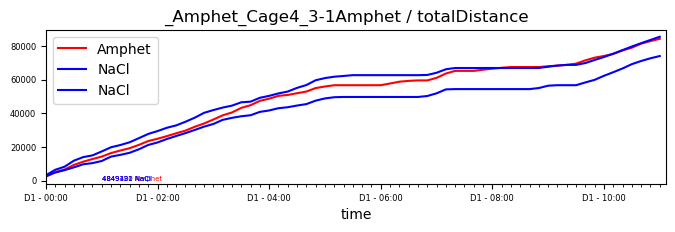

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221103_Amphet_Cage3_4-1Amphet.sqlite
expName is:  _Amphet_Cage3_4-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:3 Name:C RFID:000004849094 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849177 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849427 Genotype:NaCl User1:None
000004849094
totalDistance  Id( 3 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  88.24946641921997 S )
Computing the distance:
Animal Id:3 Name:C RFID:000004849094 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=3 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:3 Name:C RFID:000004849094 Genotype:Amphet User1:None   747130  detections loaded in 19.41050124168396 seconds.
Compute total distance

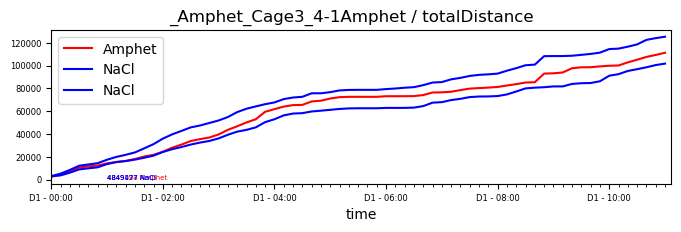

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221103_Amphet_Cage4_4-1Amphet.sqlite
expName is:  _Amphet_Cage4_4-1Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000004849491 Genotype:Amphet User1:None
Animal Id:1 Name:A RFID:000004849182 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849320 Genotype:NaCl User1:None
000004849491
totalDistance  Id( 2 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  78.21551895141602 S )
Computing the distance:
Animal Id:2 Name:B RFID:000004849491 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:2 Name:B RFID:000004849491 Genotype:Amphet User1:None   849643  detections loaded in 19.771875858306885 seconds.
Compute total distanc

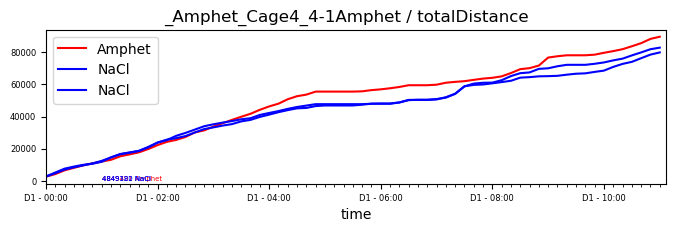

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221104_Amphet_Cage3_weekend2.sqlite
expName is:  4_Amphet_Cage3_weekend2
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849094 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849427 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849177 Genotype:NaCl User1:None
000004849094
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  95.68801641464233 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849094 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849094 Genotype:NaCl User1:None   868108  detections loaded in 19.542810678482056 seconds.
Compute total distance min:0

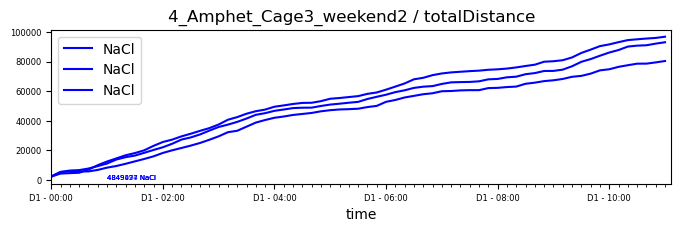

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221104_Amphet_Cage4_weekend2.sqlite
expName is:  4_Amphet_Cage4_weekend2
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849320 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849182 Genotype:NaCl User1:None
000004849491
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  117.00142025947571 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None   744159  detections loaded in 17.03570795059204 seconds.
Compute total distance min:0

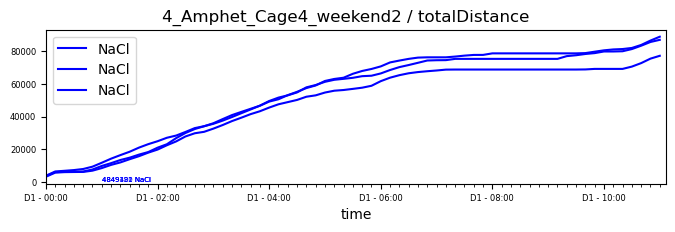

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221107_Amphet_Cage3_5-3Amphet.sqlite
expName is:  _Amphet_Cage3_5-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849094 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849427 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849177 Genotype:Amphet User1:None
000004849094
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  71.80403399467468 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849094 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849094 Genotype:Amphet User1:None   801508  detections loaded in 17.41443681716919 seconds.
Compute total dist

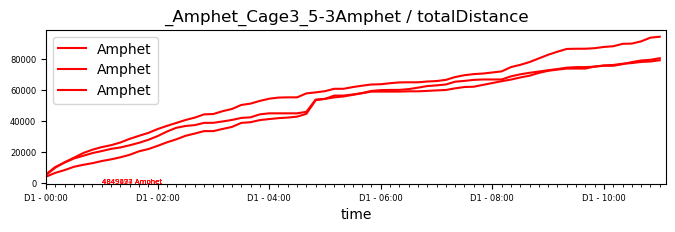

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221107_Amphet_Cage4_5-3Amphet.sqlite
expName is:  _Amphet_Cage4_5-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849491 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849182 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849320 Genotype:Amphet User1:None
000004849491
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  70.8416314125061 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849491 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849491 Genotype:Amphet User1:None   774400  detections loaded in 17.325042486190796 seconds.
Compute total dist

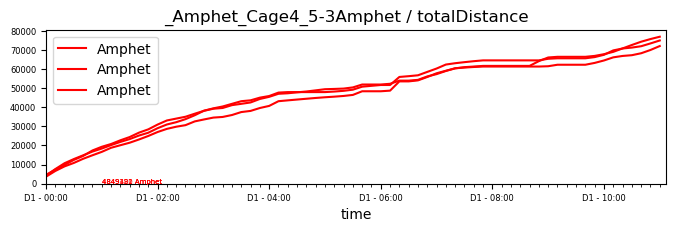

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221108_Amphet_Cage3_6-3Amphet.sqlite
expName is:  _Amphet_Cage3_6-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849427 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849094 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849177 Genotype:Amphet User1:None
000004849427
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  120.40612888336182 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849427 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849427 Genotype:Amphet User1:None   1001516  detections loaded in 24.933261156082153 seconds.
Compute total d

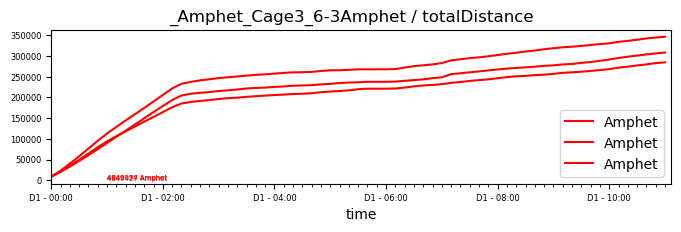

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221108_Amphet_Cage4_6-3Amphet.sqlite
expName is:  _Amphet_Cage4_6-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849182 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849491 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849320 Genotype:Amphet User1:None
000004849182
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  19.07485866546631 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849182 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849182 Genotype:Amphet User1:None   1100633  detections loaded in 25.500235319137573 seconds.
Compute total di

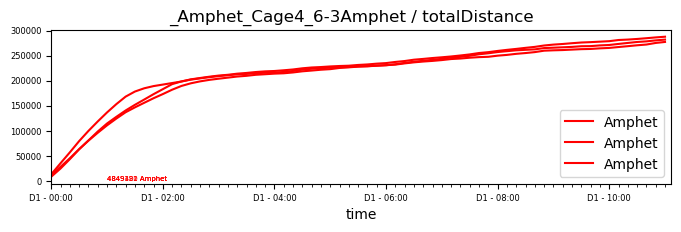

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221109_Amphet_Cage3_7-3Amphet.sqlite
expName is:  _Amphet_Cage3_7-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849177 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849094 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849427 Genotype:Amphet User1:None
000004849177
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  107.25702476501465 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849177 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849177 Genotype:Amphet User1:None   1037498  detections loaded in 25.019588232040405 seconds.
Compute total d

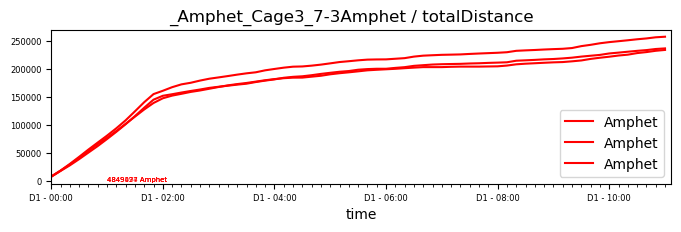

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221109_Amphet_Cage4_7-3Amphet.sqlite
expName is:  _Amphet_Cage4_7-3Amphet
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849320 Genotype:Amphet User1:None
Animal Id:2 Name:B RFID:000004849182 Genotype:Amphet User1:None
Animal Id:3 Name:C RFID:000004849491 Genotype:Amphet User1:None
000004849320
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  115.02510046958923 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849320 Genotype:Amphet User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849320 Genotype:Amphet User1:None   1012482  detections loaded in 22.810843229293823 seconds.
Compute total d

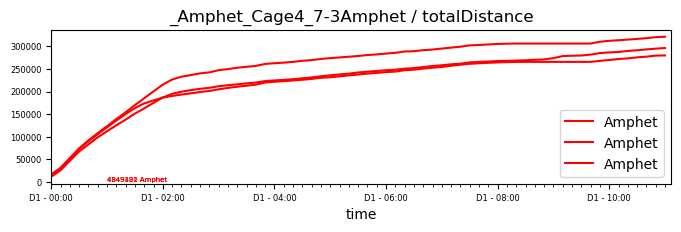

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221110_Amphet_Cage3_8-3NaCl.sqlite
expName is:  10_Amphet_Cage3_8-3NaCl
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849427 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849094 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849177 Genotype:NaCl User1:None
000004849427
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  178.53551506996155 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849427 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849427 Genotype:NaCl User1:None   884266  detections loaded in 21.500425100326538 seconds.
Compute total distance min:0

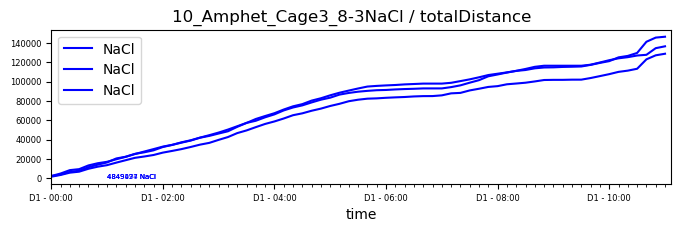

*** ALL JOBS DONE *** 
E:/LMT + Amphetamine/LMT recordings (DBs rebuilt)/221110_Amphet_Cage4_8-3NaCl.sqlite
expName is:  10_Amphet_Cage4_8-3NaCl
Loading animals ...
Fields available in lmtanalysis Z:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849320 Genotype:NaCl User1:None
Animal Id:3 Name:C RFID:000004849182 Genotype:NaCl User1:None
000004849491
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 1200000 ) Loaded ( 0  records loaded in  153.88435983657837 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=1200000
Animal Id:1 Name:A RFID:000004849491 Genotype:NaCl User1:None   989247  detections loaded in 21.38190197944641 seconds.
Compute total distance min:0 

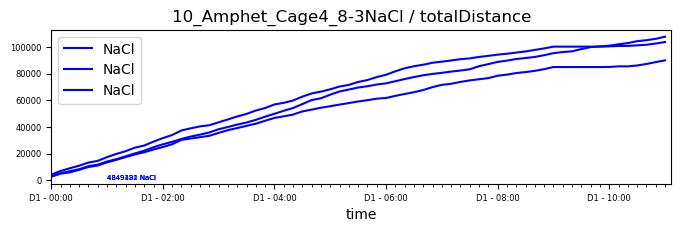

*** ALL JOBS DONE *** 


In [20]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTInput,getFrameInput


def frameToTimeTicker(x, pos):
   
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    
if __name__ == '__main__':
    
    print("Code launched.")
    #Choose the files to process
    files = getFilesToProcess()
    tmin = getFrameInput("Start")
    tmax = getFrameInput("End")

    nbTimeBins = int((tmax-tmin)/18000) #10min = 18000frames
    timebins = []
    
    print(f"There will be {nbTimeBins} bins of 10min (18000frames) in the graph")
    for i in range(nbTimeBins+1):
        timebins.append(i * 18000)
        
    print(f"The timebinList is: {timebins} \n")   
    print(f" with a length of {len(timebins)}.")
    
    """
    behavioralEvents = ["Contact", "Oral-oral Contact", "Oral-genital Contact", "Side by side Contact", 
                        "Side by side Contact, opposite way", "Social approach", "Get away", "Approach contact", 
                        "Approach rear", "Break contact", "FollowZone Isolated", "Train2", "Group2", "Group3", "Group4",
                        "Group 3 break", "Group 3 make", "Group 4 break", "Group 4 make", "Move isolated", 
                        "Move in contact", "Rear isolated", "Rear in contact", "Stop isolated", 
                        "WallJump","totalDistance", "Fight", "Won Fight", "Lost Fight", "SAP"]
    """
    behavioralEvents = ["totalDistance"]
    animalTotalDistance = {}
    animalDistancePerBin = {}
    listCumulated = {}
    listValue = {}
    
    # print(behavioralEvents)
    
    # behaviorToPlot = input("Which behavior do you want to plot the Cumulated graph? (No choice here... totalDistance) : ")
    
    behaviorToPlot = "totalDistance"
    
    print("\n This script will plot the totalDistance traveled by the mice in the selected database... \n")
    
    saveFile = f"figTimeLine-{behaviorToPlot}"

    for file in files:
        print(file)
        expName = file[-30:-7] #Select the name of XP in the filename
        print("expName is: ", expName )
        
        connection = sqlite3.connect( file )
    
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        """        
        pool.loadDetection( start = tmin, end = tmax, lightLoad=True)
        """
        
        #Load the timeline of the event over all individuals
        behaviorTimeLine = {}

        for animal in pool.animalDictionnary.keys():
            print( pool.animalDictionnary[animal].RFID )
            behaviorTimeLine[animal] = EventTimeLine( connection, behaviorToPlot, idA=animal, minFrame=tmin, maxFrame=tmax )
#             behaviorTimeLine[animal].removeEventsBelowLength( maxLen = MIN_WATER_STOP_DURATION )

            print("Computing the distance:")
            pool.animalDictionnary[animal].loadDetection( start=tmin, end=tmax, lightLoad = True )
            animalTotalDistance[animal] = pool.animalDictionnary[animal].getDistance(tmin,tmax)/100 # Total distance in meters (m)
            tenMinBin = 10*30*60 #Bins of 10 minutes = 18000 frames
            print("The time bin is 10min = 18 000 frames.")
            animalDistancePerBin[animal] = pool.animalDictionnary[animal].getDistancePerBin(binFrameSize = tenMinBin , minFrame=tmin, maxFrame=tmax ) # in centimeters (m)
            
            print("\n")
            print(f"The animalDistancePerBin for animal {animal} is:")
            print(animalDistancePerBin[animal])
            print(f"of lenght {len(animalDistancePerBin[animal])}.")
        
        # Build the plot
        fig, ax = plt.subplots(1,1 , figsize=(8, 2 ) )
        ax = plt.gca() # get current axis
        #ax.set_ylim([ymin, ymax])
        
        #set x axis
        ax.set_xlabel("time")
        ax.set_xlim([0, tmax])
        formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(labelsize=6 )
        ax.xaxis.set_major_locator(ticker.MultipleLocator( 18000 * 12 )) # 10min = 18000 frames
        ax.xaxis.set_minor_locator(ticker.MultipleLocator( 18000 ))
                
        # Draw the rectangles for the nights
#         print("loading night events for file " + file)
#         nightTimeLine = EventTimeLine( connection, "night" , minFrame=tmin, maxFrame=tmax )
        
#         for nightEvent in nightTimeLine.getEventList():
#             ax.axvspan( nightEvent.startFrame, nightEvent.endFrame, alpha=0.1, color='black')
#             ax.text( nightEvent.startFrame+(nightEvent.endFrame-nightEvent.startFrame)/2 , 200 , "dark phase" ,fontsize=6, ha='center')
        
        totalDistance = {}
        timeBin = 1
        
        #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
        legendHeight = 60
        rfids_legend = []
        geno_legend = []
        
        for animal in pool.animalDictionnary.keys():
            rfids_legend.append(pool.animalDictionnary[animal].RFID[4:])
            geno_legend.append(pool.animalDictionnary[animal].genotype)
            
            # if "Amphet" in pool.animalDictionnary[animal].genotype:
            #     color = "red"
            # else:
            #     color="blue" 
            # print ( pool.animalDictionnary[animal].RFID )
            
#             ax.text(30*60*60, legendHeight, "{} {}".format(pool.animalDictionnary[animal].RFID[5:], 
#                                                            pool.animalDictionnary[animal].genotype), color = color, fontsize=5)
            
# #                     color=getAnimalColor(animal), fontsize=5 )
#             legendHeight += 30 

        print("\n")
        print(f"RFID legends: {rfids_legend}")
        print(f"Geno legends: {geno_legend}")
             
        for animal in pool.animalDictionnary.keys():
            # print(f"\n Animal {animal}")
            # listCumulated = []
            # listValue = behaviorTimeLine[animal].getDurationEventInTimeBin( tmin=tmin, tmax=tmax, binSize=timeBin*oneMinute)
            
            listValue[animal] = animalDistancePerBin[animal]
            
            cumul = 0 # To compute the cumulative value of the event (totalDistance here)
            cumulList = []
            for value in listValue[animal]:
                cumul+= value
                # listCumulated[animal].append(cumul)
                cumulList.append(cumul)
                
            totalDistance[animal]= cumulList # totalDistance is a dict with 'animal number' as key and the list of cumulated Distance in values
        
            # print(f"\n Total distance : {totalDistance[animal]} for animal : {animal}.")
        
        print("\n nbtimebins: ", nbTimeBins)
        
        # abs = [1*oneMinute]
        # for t in range(1, nbTimeBins):
        #     x = abs[t-1] + timeBin*oneMinute
        #     abs.append(x)
        
        # Check if timebins and totalDistance have the same size :
        while len(timebins) > len(totalDistance[1]):
            timebins = timebins.pop()
            print("popped last timebin value")  
            
        for animal in totalDistance:
            if "Amphet" in pool.animalDictionnary[animal].genotype:  # AMPHET mice in RED
                color = "red"
            else:  # NACL mice in BLUE
                color="blue"
            # ax.plot( abs, totalDistance[animal] , color= color) # color= getAnimalColor( animal )
            
            ax.text(30*60*60, legendHeight, "{} {}".format(pool.animalDictionnary[animal].RFID[5:], 
                                                           pool.animalDictionnary[animal].genotype), color = color, fontsize=5)
            
#                     color=getAnimalColor(animal), fontsize=5 )
            legendHeight += 30 
    
            print(f"\n TotalDistance of animal {animal}: {totalDistance[animal]}")
            
            ax.plot(timebins, totalDistance[animal] , color= color) # color= getAnimalColor( animal )

                
        ax.legend(geno_legend) #ADD THE GENOTYPE AS LEGEND
        fig.suptitle(f"{expName} / {behaviorToPlot}")

        figName = f"FigCumul-{behaviorToPlot}_{expName}.png"
        print (behaviorToPlot)
        print(expName)
        print ("Saving figure... \n" , figName )
        fig.savefig( figName ,dpi=100)
        
        plt.show()
        plt.close( fig )
        
        connection.close() #Stop connection to the DBs
        
        print( "*** ALL JOBS DONE *** ")


In [11]:
behaviorDuration

{2: 15867.04411508765, 1: 18416.75509121774, 3: 12231.452091771182}

In [13]:
len(behaviorDuration[2])

72

In [9]:
for i in animalDistancePerBin:
    print(i)

1
2
3
